In [1]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
import scipy
from natsort import natsorted
from sklearn.mixture import GaussianMixture

from skimage.registration import phase_cross_correlation
from scipy import ndimage as scp
from tqdm import tqdm
from skimage.metrics import normalized_root_mse as nrm
from statsmodels.tsa.stattools import acf
import pickle
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
import time
import math
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
from skimage.feature import SIFT, match_descriptors,plot_matches
from skimage.feature import ORB

import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz
from scipy import optimize
from itertools import permutations 
from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse
from tifffile import imread as tiffread


In [2]:
def load_data(path_num,path_all = False):
    # if (path_num==0) or (path_num=='before'):
    #     path = 'rgb/before/'
    # elif (path_num==1) or (path_num=='after'):
    #     path = 'rgb/after/'
    # elif (path_num==2) or (path_num=='after_2min'):
    if path_all:
        path = path_all
    else:
        path = f'registered/{path_num}/'
    pic_paths = []
    for i in os.listdir(path):
        if i.endswith('.dcm') or  i.endswith('.tiff') or i.endswith('.PNG'):
            pic_paths.append(i)
    pic_paths = natsorted(pic_paths)

    temp_img = cv2.imread(path+pic_paths[0],cv2.IMREAD_UNCHANGED) 
    imgs_from_folder = np.zeros((len(pic_paths),temp_img.shape[0],temp_img.shape[1]))
    # imgs_from_folder = []
    for i,j in enumerate(pic_paths):
        aa = cv2.imread(path+j,cv2.IMREAD_UNCHANGED)
        imgs_from_folder[i] = aa.copy()
    imgs_from_folder = imgs_from_folder.astype(np.float32)
    return imgs_from_folder


def ants_reg_mapping(stat,mov):
    ants1 = ants.from_numpy(stat.astype(np.float32))
    ants2 = ants.from_numpy(mov.astype(np.float32))
    # mov_mask = ants.from_numpy(moving_mask.astype(np.float64))
    reg = ants_register(ants1,ants2,type_of_transform = 'Translation',
                        aff_iterations=(1100, 1200, 1000, 1000))
    # reg_img = ants.apply_transforms(ants2, ants1, reg['fwdtransforms'])
    return reg['fwdtransforms']


def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(0,shif[0]))
    warped = warp(x, tform,order=3)
    return -ncc(y,warped)


def ncc(a,b):
    # print(np.linalg.norm(a),np.linalg.norm(b))
    a = a / np.linalg.norm(a) if np.linalg.norm(a)!=0 else a / 10
    b = b / np.linalg.norm(b) if np.linalg.norm(b)!=0 else b / 10
    # print(np.correlate(a.flatten(), b.flatten(), mode = 'full'))
    return np.correlate(a.flatten(), b.flatten())

def min_max(data1):
    if np.all(data1 == data1[0]):
        return data1
    else:
        data1 = (data1-np.min(data1))/(np.max(data1)-np.min(data1))
        return data1

def bottom_extract(data,mid):
    test = np.max(data.transpose(2,1,0),axis=0).copy()
    kk = fftshift(fft2(test[-(data[0].shape[0]-mid):-80]))
    filt = np.ones_like(kk)
    filt[(filt.shape[0]//2)-5:(filt.shape[0]//2)+5,(filt.shape[1]//2)-5:(filt.shape[1]//2)+5] = 0
    kk = kk*filt
    kk = np.abs(ifft2(fftshift(kk)))
    max_list = np.max(kk,axis=1)
    thresh = threshold_otsu(max_list)
    mir_UP_x, mir_DOWN_x = np.where(max_list>=thresh)[0][0]+mid, np.where(max_list>=thresh)[0][-1]+mid
    UP_x,DOWN_x = ((2*mid - mir_UP_x)-(mir_DOWN_x - mir_UP_x)), (2*mid - mir_UP_x)
    return UP_x,DOWN_x,mir_UP_x,mir_DOWN_x

In [3]:
all_reg = natsorted([i for i in os.listdir('registered/') if i.startswith('scan')])

In [4]:
datas = {}
for paths in all_reg:
    print(f'Loading data: {paths}')
    datas[paths] = load_data(paths)

Loading data: scan1
Loading data: scan2
Loading data: scan3
Loading data: scan4
Loading data: scan5
Loading data: scan6
Loading data: scan7
Loading data: scan8
Loading data: scan9
Loading data: scan10
Loading data: scan11
Loading data: scan12
Loading data: scan13
Loading data: scan14
Loading data: scan15
Loading data: scan16
Loading data: scan17
Loading data: scan18
Loading data: scan19
Loading data: scan20
Loading data: scan21
Loading data: scan22
Loading data: scan23
Loading data: scan24
Loading data: scan25
Loading data: scan26
Loading data: scan27


In [10]:
def find_mid(data):
    n = data.shape[1]
    mid = (np.argmax(np.sum(data[0][:n//2],axis=1)) + data[0].shape[0])//2
    return mid


def bottom_extract(data,mid):
    test = np.max(data.transpose(2,1,0),axis=0).copy()
    kk = fftshift(fft2(test[-(data[0].shape[0]-mid):-80]))
    filt = np.ones_like(kk)
    filt[(filt.shape[0]//2)-5:(filt.shape[0]//2)+5,(filt.shape[1]//2)-5:(filt.shape[1]//2)+5] = 0
    kk = kk*filt
    kk = np.abs(ifft2(fftshift(kk)))
    max_list = np.max(kk,axis=1)
    thresh = threshold_otsu(max_list)
    mir_UP_x, mir_DOWN_x = np.where(max_list>=thresh)[0][0]+mid, np.where(max_list>=thresh)[0][-1]+mid
    UP_x,DOWN_x = ((2*mid - mir_UP_x)-(mir_DOWN_x - mir_UP_x)), (2*mid - mir_UP_x)
    return UP_x,DOWN_x,mir_UP_x,mir_DOWN_x

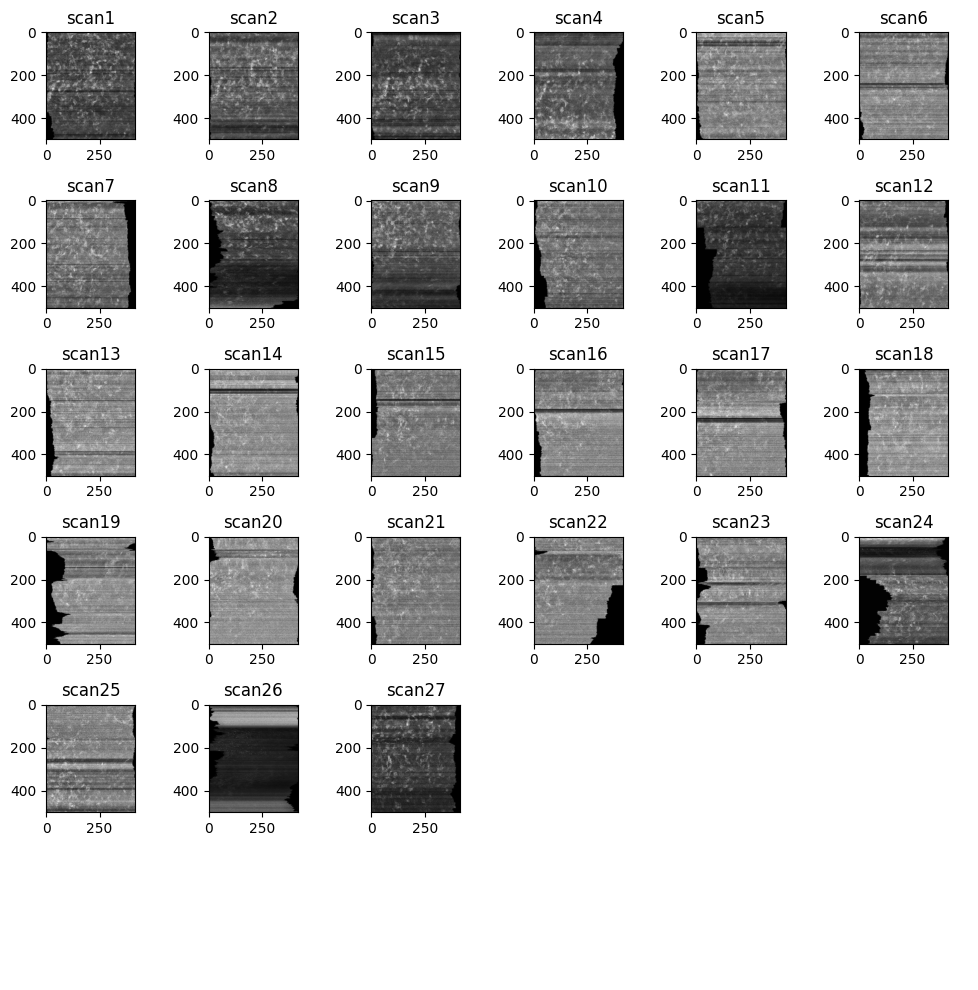

In [6]:
grid_size = int(np.ceil(np.sqrt(len(all_reg))))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
axes = axes.flatten()

for i,j in enumerate(all_reg):
    _,_,mir_UP,mir_DOWN = bottom_extract(datas[j],find_mid(datas[j]))
    axes[i].imshow(equalize_adapthist(min_max(np.mean(datas[j].transpose(1,0,2)[mir_UP:mir_DOWN],axis=0))), cmap='gray')
    axes[i].set_title(all_reg[i])
    # axes[i].axis('off')  # Turn off axis labels

# If the number of images doesn't perfectly fill the grid, hide extra subplots
for i in range(len(all_reg), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
# plt.savefig('all_nerves_post_registration.PNG',dpi=500)
plt.show()

In [9]:
def non_zero_crop(a,b):
    mini = max(np.min(np.where(a[0]!=0)),np.min(np.where(b[0]!=0)))
    maxi = min(np.max(np.where(a[0]!=0)),np.max(np.where(b[0]!=0)))
    return mini, maxi

def denoise_fft(data):
    kk = fftshift(fft2(data))
    filt = np.ones_like(kk)
    filt[(filt.shape[0]//2)-5:(filt.shape[0]//2)+5,(filt.shape[1]//2)-5:(filt.shape[1]//2)+5] = 0
    kk = kk*filt
    kk = np.abs(ifft2(fftshift(kk)))
    return kk

In [131]:
non_zero_crop(datas['scan19'][401][np.r_[x:y,a:b]],datas['scan19'][20][np.r_[x:y,a:b]])

(50, 394)

In [213]:
from skimage.metrics import structural_similarity as ssim

In [126]:
def calculate_mad_efficient(data):    
    return np.median(np.abs(data - np.median(data)))

def outlier(data):
    mu  = np.mean(data[:15])
    std = np.std(data[:15])
    x = data[-1]
    if abs(x-mu) > 3*std:
        return True
    return False

In [183]:
errs = []
k = 0
mad = []
x,y,a,b = bottom_extract(datas['scan23'],find_mid(datas['scan23']))
for i in (range(5,datas['scan23'].shape[0]-1)):
    x_zero_offset, y_zero_offset = non_zero_crop(datas['scan23'][i][np.r_[x:y,a:b]],datas['scan23'][i+1][np.r_[x:y,a:b]])
    temp_e = (1-ncc(min_max(denoise_fft(np.vstack((min_max(datas['scan23'][i][x:y][:,x_zero_offset:y_zero_offset])
                                                    ,min_max(datas['scan23'][i][a:b][:,x_zero_offset:y_zero_offset])))))
                    ,min_max(denoise_fft(np.vstack((min_max(datas['scan23'][i+1][x:y][:,x_zero_offset:y_zero_offset])
                                                    ,min_max(datas['scan23'][i+1][a:b][:,x_zero_offset:y_zero_offset])))))))
    if k>15:
        mad.append(outlier(errs[-16:]))
    k+=1
    errs.append(temp_e[0])
    # mad.append(calculate_mad_efficient(errs[-10:]))

In [221]:
from scipy.signal import find_peaks

find_peaks(errs_smooth[25:-25])

(array([  7,  29,  49,  54,  57,  62,  71,  80,  82,  87,  93,  96,  98,
        100, 117, 124, 128, 147, 161, 168, 187, 199, 207, 210, 231, 233,
        235, 250, 265, 278, 280, 301, 303, 312, 316, 318, 332, 335, 343,
        349, 352, 359, 363, 365, 371, 380, 384, 391, 396, 405, 407, 413,
        424, 431, 435, 437, 442, 446, 448]),
 {})

In [223]:
AffineTransform(translation=(10,0))

<AffineTransform(matrix=
    [[ 1., -0., 10.],
     [ 0.,  1.,  0.],
     [ 0.,  0.,  1.]]) at 0x1c099eb50>

In [228]:
np.dot(np.dot(np.eye(3),AffineTransform(translation=(10,0))),AffineTransform(translation=(10,0)))

array([[ 1.,  0., 20.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [138]:
import pywt

def detect_peaks_wavelet_transform(data):
    coeffs = pywt.wavedec(data, 'haar', level=1)
    denoised_data = pywt.waverec(coeffs, 'haar')
    peaks = np.where((denoised_data[1:-1] > denoised_data[:-2]) & (denoised_data[1:-1] > denoised_data[2:]))[0] + 1
    return peaks

data = errs_smooth[25:-25]
peaks = detect_peaks_wavelet_transform(data)
print(peaks)  

[ 10  12  20  22  32  34  44  46  52  54  58  68  70  72  74  76  80  82
  84  86  88  90  92  94  96  98 100 102 104 106 108 110 112 114 116 118
 122 126 128 132 134 136 144 148 168 172 184 192 200 208 210 216 222 254
 256 258 264 270 272 274 286 288 290 292 294 298 300 306 308 312 314 316
 318 320 322 330 332 336 338 340 342 346 348 356 359 362 364 366 370 372
 374 376 388 390 394 400 402 404 416 427 434 436 440 442 454 458 460 462
 466 468 470]


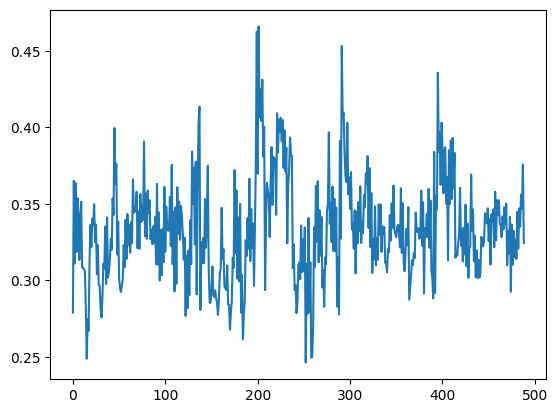

In [184]:
plt.plot(np.array(errs[5:]))

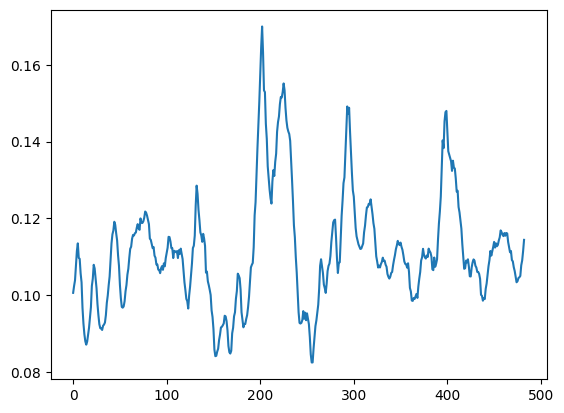

In [185]:

errs_smooth = np.convolve(np.array(errs).flatten(), np.ones(10)/10)
plt.plot(errs_smooth[10:-10]**2)

In [206]:
kk = fft(errs_smooth[10:-10])
kk[10:] = 0
kk = abs(ifft(kk))

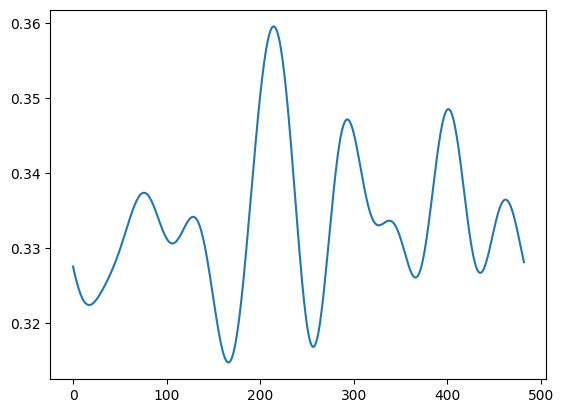

In [207]:
plt.plot(kk)

In [209]:
find_peaks(kk,width=25)[0]

array([ 76, 214, 293, 401, 462])

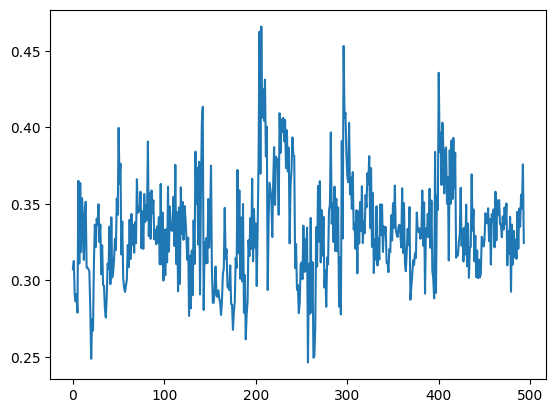

In [177]:
plt.plot(errs)